In [65]:
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit

In [66]:
# import csv file
ev_df = pd.read_csv('data/Cleaned data/ev_df_copy.csv')

# Create a datetime index based on 'Year' and 'Quarter' columns
ev_df['Date'] = pd.to_datetime(ev_df['Year'].astype(str) + 'Q' + ev_df['Quarter'].astype(str))

# Read in ev_sentiment_df
ev_sentiment_df = pd.read_csv('data/ev_sentiment_df.csv')
ev_sentiment_df['ds'] = pd.to_datetime(ev_sentiment_df['ds'])

# Create dictionary of sentiment scores for each ds
sentiment_dict = dict(zip(ev_sentiment_df['ds'], ev_sentiment_df['yhat']))

# Create new column in ev_df for sentiment scores
ev_df['Sentiment'] = ev_df['Date'].map(sentiment_dict)
ev_df.set_index('Date', inplace=True)


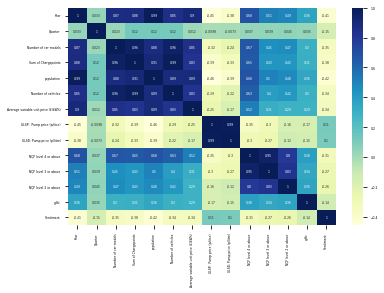

In [67]:
# correlation heatmap for ev_df
corr = ev_df.corr()
sns.heatmap(corr, cmap="YlGnBu", annot=True)
# make text in heatmap smaller
plt.rcParams['font.size'] = 3
plt.show()

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17126D+01    |proj g|=  1.74179D+00

At iterate    5    f=  1.15695D+01    |proj g|=  6.77818D-02

At iterate   10    f=  1.15410D+01    |proj g|=  1.45071D-02

At iterate   15    f=  1.15390D+01    |proj g|=  1.40403D-01

At iterate   20    f=  1.13522D+01    |proj g|=  1.01261D+00

At iterate   25    f=  1.12982D+01    |proj g|=  4.56649D-01

At iterate   30    f=  1.12956D+01    |proj g|=  4.75625D-04

At iterate   35    f=  1.12952D+01    |proj g|=  3.17357D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

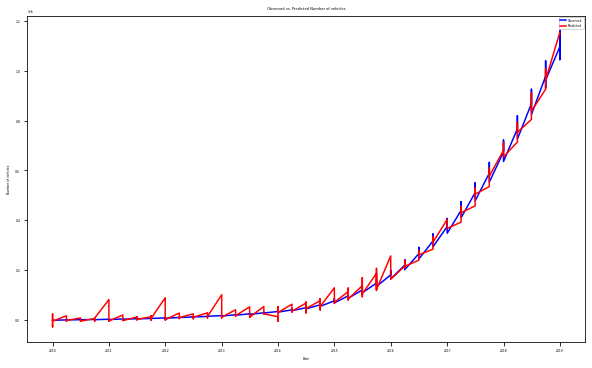

In [68]:


# Define your dependent variable and explanatory variables
dependent_var = 'Number of vehicles'
explanatory_vars = ['population', 'Average variable unit price (£/kWh)',
                    'Sum of Chargepoints', 'Number of car models']

# split into train/test datasets
train_df = ev_df[:'2019-03-31']
test_df = ev_df['2019-04-01':]

# Fit the SARIMAX model
endog = train_df[dependent_var]
exog = train_df[explanatory_vars]
sarimax_model = SARIMAX(endog, exog=exog, order=(1, 0, 1), seasonal_order=(1, 0, 1, 4))
sarimax_result = sarimax_model.fit()

# Print the summary of the SARIMAX model
print(sarimax_result.summary())


# Get the predicted values from the SARIMAX model
predicted_values = sarimax_result.predict(start=exog.index[0], end=exog.index[-1], exog=exog)

# Plot the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(endog.index, endog, label='Observed', color='blue')
plt.plot(predicted_values.index, predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of vehicles')
plt.title('Observed vs. Predicted Number of vehicles')
plt.legend()
plt.show()


Normaltest p-value: 7.605013561951048e-16


/opt/homebrew/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


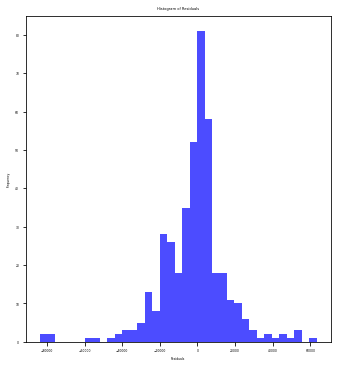

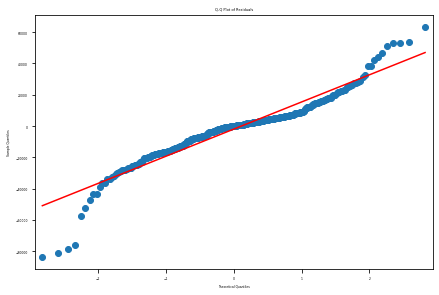

In [69]:


# Assuming 'sarimax_result' contains the fitted SARIMAX model results

# Get the residuals from the fitted model
residuals = sarimax_result.resid

# Shapiro-Wilk test for normality
normaltest_result = stats.normaltest(residuals)
print("Normaltest p-value:", normaltest_result.pvalue)

# Visual inspection: Histogram and Q-Q plot
plt.figure(figsize=(12, 6))

# Histogram of residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins='auto', color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')

# Q-Q plot of residuals
plt.subplot(1, 2, 2)
sm.graphics.qqplot(residuals, line='s', color='blue')
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()


/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


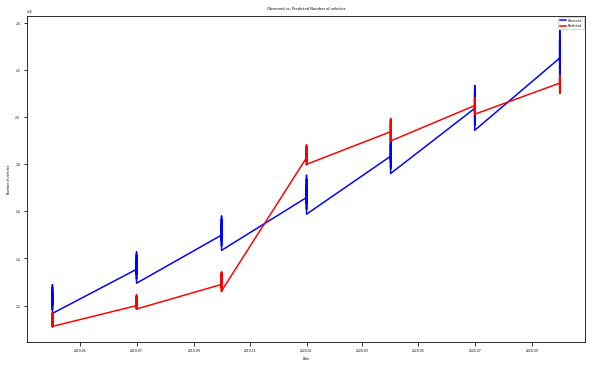

In [70]:

endog_test = test_df[dependent_var]
exog_test = test_df[explanatory_vars]

predicted_values = sarimax_result.forecast(84, exog=test_df[explanatory_vars])
predicted_values.index = test_df.index

# Plot the observed and predicted values
plt.figure(figsize=(10, 6))
plt.plot(endog_test.index, endog_test, label='Observed', color='blue')
plt.plot(predicted_values.index, predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Number of vehicles')
plt.title('Observed vs. Predicted Number of vehicles')
plt.legend()
plt.show()

In [71]:


# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(endog_test, predicted_values)
rmse = np.sqrt(mse)
r2 = r2_score(endog_test, predicted_values)

print(f"R-squared (R2 ): {r2}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")



R-squared (R2 ): 0.8451896666053208
Mean Squared Error (MSE): 18731798862.5227
Root Mean Squared Error (RMSE): 136864.16208241915
